<a href="https://colab.research.google.com/github/williamcarp/Equity-Derivative-Models/blob/main/Notebooks/Equity_Derivative_Pricing_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Equity Derivative Pricing Models**

Author:       Will Carpenter

Date Created: April 1st, 2021

Models Implemented: CRR Binomial, CRR Trinomial, JR Binomial, and Black-Scholes Formula.



## Importing

In [20]:
import math 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.stats import norm # Cumulative normal distribution
from scipy.optimize import fsolve # non-linear root-finding

## CRR Binomial Tree 

The CRR binomial tree program is given below.

Space should be O(n). Runtime is O(n^2). 

In [21]:
def crr_binomial_tree(S, K, r, T, t, v, style, type):

    # S  : spot price 
    # K  : strike 
    # r  : riskless rate
    # T  : maturity (in yrs.)
    # t  : number of steps 
    # v  : annualized volatility

    # style : 'amer' or 'euro'
    # type  : 'call' or 'put

    # Calculate time increment 
    dt = T / t 
    
    # Set type of option 
    if type=='call': x = 1 
    if type=='put' : x = -1 
    
    # Initialize tree  
    crrTree      = np.empty((t+1,1))
    crrTree[:]   = np.nan

    # Initialize tree parameters 
    u = math.exp(v*math.sqrt(dt))
    d = 1/u
    p = (math.exp(r*dt) - d)/(u - d)

    for row in range(0,t+1):
        St = S*u**(t-row)*d**(row)
        crrTree[row, 0] = max(x*St - x*K, 0)

    for col in range(t-1, -1, -1):
        for row in range(0, col+1):
            
            # Determine value of early excercise 
            if style=='euro':   earlyExercise = np.NINF
            if style=='amer':   earlyExercise = x*S*u**(col-row)*d**(row) - x*K

            # Backward iteration from previous nodes
            Pu = crrTree[row, 0]
            Pd = crrTree[row+1, 0]
            # Determine continuation value 
            continuation = math.exp(-r*dt)*(p*Pu + (1-p)*Pd)
            
            # Calcuate price on at tree node
            crrTree[row, 0] = max(continuation, earlyExercise)

    return crrTree[0,0]

## CRR Trinomial Tree

In [32]:
def crr_trinomial_tree(S, K, r, T, t, v, style, type):

    # S  : spot price 
    # K  : strike 
    # r  : riskless rate
    # T  : maturity (in yrs.)
    # t  : number of steps 
    # v  : annualized volatility

    # style : 'amer' or 'euro'
    # type  : 'call' or 'put

    # Calculate time increment 
    dt = T / t

    # Set type of option 
    if type=='call': x = 1 
    if type=='put' : x = -1 

    # Initialize tree  
    crrTree        = np.empty((2*t+1,1))
    crrTree[:]     = np.nan

    # Initialize tree parameters 
    u = math.exp(v*math.sqrt(2*dt))
    d = 1/u
    m = 1
    
    # Pu
    pu = ((math.exp(r*dt/2) - math.exp(-1*v*math.sqrt(dt/2))) / 
         (math.exp(v*math.sqrt(dt/2)) - math.exp(-1*v*math.sqrt(dt/2))))**2
    # Pd
    pd = ((math.exp(v*math.sqrt(dt/2)) - math.exp(r*dt/2)) /
         (math.exp(v*math.sqrt(dt/2)) - math.exp(-1*v*math.sqrt(dt/2))))**2
    # Pm
    pm = 1 - (pu + pd)

    for row in range(0, 2*t+1):
        St = S*u**(max(t-row,0))*d**(max(row-t,0))
        crrTree[row, 0] = max(x*St-x*K,0)


    for col in range(t-1, -1, -1):
        for row in range(0, col*2+1):

            # Determine value of early excercise 
            if style=='euro':   earlyExercise = np.NINF
            if style=='amer':   earlyExercise = x*S*u**(max(col-row,0))*d**(max(row-col,0)) - x*K
            
            # move backwards from previous prices 
            Su = crrTree[row,   0]
            Sm = crrTree[row+1, 0]
            Sd = crrTree[row+2, 0]
            # Calcuate price on tree
            continuation = math.exp(-r*dt)*(pu*Su + pm*Sm + pd*Sd)


            crrTree[row, 0] = max(continuation, earlyExercise)

    return crrTree[0,0]

## Jarrow-Rudd Binomial Tree

An adaptation of the CRR market model where it is assumed that probability is equal to 1/2 through the tree.

In [23]:
def jr_binomial_tree(S, K, r, T, t, v, style, type):

    # S  : spot price 
    # K  : strike 
    # r  : riskless rate
    # T  : maturity (in yrs.)
    # t  : number of steps 
    # v  : annualized volatility

    # style : 'amer' or 'euro'
    # type  : 'call' or 'put

    # Calculate time increment 
    dt = T / t

    # Set type of option 
    if type=='call': x = 1 
    if type=='put' : x = -1 

    jrTree        = np.empty((t+1,1))
    jrTree[:]     = np.nan

    # Initialize tree parameters 
    u = math.exp((r - v**2/2)*dt + v*math.sqrt(dt))
    d = math.exp((r - v**2/2)*dt - v*math.sqrt(dt))
    p = 1/2

    for row in range(0,t+1):
        St = S*u**(t-row)*d**(row)
        jrTree[row, 0] = max(x*St - x*K, 0)

    for col in range(t-1, -1, -1):
        for row in range(0, col+1):

            # Determine value of early excercise 
            if style=='euro':   earlyExercise = np.NINF
            if style=='amer':   earlyExercise = x*S*u**(col-row)*d**(row) - x*K

            # Backward iteration from previous nodes
            Pu = jrTree[row, 0]
            Pd = jrTree[row+1, 0]
            
            # Determine continuation value
            continuation = math.exp(-r*dt)*(p*Pu + (1-p)*Pd)

            # Calcuate price on at tree node
            jrTree[row, 0] = max(continuation, earlyExercise)

    return jrTree[0,0]

## Black-Scholes Option Pricing Formula

By design, prices given by the CRR binomial and trinomial tree should converge to Black-Scholes pricing as the number of steps increases.

In [24]:
def black_scholes(S, K, r, T, t, v, style, type):

    # Black-Scholes does not accomodate American options 

    # S  : spot price 
    # K  : strike 
    # r  : riskless rate
    # T  : maturity (in yrs.)
    # t  : number of steps 
    # v  : annualized volatility

    # Set type of option 
    if type=='call': x = 1 
    if type=='put' : x = -1 

    d1 = (math.log(S/K) + (v**2/2 + r)*T)/(v*math.sqrt(T))
    d2 = (d1 - v*math.sqrt(T))

    return x*S*norm.cdf(x*d1) - x*K*math.exp(-r*T)*norm.cdf(x*d2)

In [ ]:
def ivol(P, K, r, T, v, style, type):

    func = black_scholes(...)
    solve black_scholes


## Visualizing the CRR Binomial Tree

Code for the CRR binomial tree can be expanded to include an additional array for the entire evolution of the underlying stock price. While this modification increases run-time and storage of the program, it is useful to have for de-bugging purposes. 

In [25]:
def crr_visualize_btree(S, K, r, T, t, v, style, type):

    # s  : spot price 
    # k  : strike 
    # r  : riskless rate
    # T  : maturity (in yrs.)
    # t  : steps 
    # v  : annualized volatility

    # Calculate time increment 
    dt = T / t 
    
    # Set type of option 
    if type=='call': x = 1 
    if type=='put' : x = -1 
    
    # Initialize tree  
    crrTree, crrPrice         = np.empty((t+1,t+1)), np.empty((t+1,t+1)) 
    crrTree[:], crrPrice[:]   = np.nan, np.nan
    
    # Initial stock price
    crrTree[0,0] = S
    
    # Initialize tree parameters 
    u = math.exp(v*math.sqrt(dt))
    d = 1/u
    p = (math.exp(r*dt) - d)/(u - d)

    if d >= 1+r or u <= 1+r:
        raise Exception("Martingale Property not satisfied.")
    
    # Creating the stock price tree 
    # Fill in top branch 
    for col in range(1,len(crrTree)):
        crrTree[0, col] = crrTree[0, col-1]*u
    # Fill in rest of tree
    for row in range(1, len(crrTree)):
        for col in range(row, len(crrTree)):
            crrTree[row, col] = crrTree[row-1, col-1]*d
    
    for row in range(0,t+1):
        St = S*u**(t-row)*d**(row)
        crrPrice[row, t] =  max(x*St - x*K, 0)

    for col in range(t-1, -1, -1):
        for row in range(0, col+1):

            # Determine value of early excercise 
            if style=='euro': earlyExercise = np.NINF
            if style=='amer': earlyExercise = x*crrTree[row, col] - x*K

            # x*S*u**(col-row)*d**(row) - x*K

            # move backwards from previous payoffs 
            Su = crrPrice[row, col+1]
            Sd = crrPrice[row+1, col+1]

            # Determine continuation value 
            continuation = math.exp(-r*dt)*(p*Su + (1-p)*Sd)
        
            # Calcuate price on tree
            # crrPrice[row, col] = math.exp(-r*dt)*(p*Su + (1-p)*Sd)  
            crrPrice[row, col] = max(continuation, earlyExercise)

    # Added code for printing and de-bugging 

    # Reporting the model parameters
    print()
    print("Inputs:\n")
    print("T : " "{:4.2f}".format(T*12) + " months")
    print("t : " "{:4.0f}".format(t) + " periods")

    print()
    print("Tree Parameters:\n")
    print("u : " "{:3.4f}".format(u))
    print("d : " "{:3.4f}".format(d))
    print("p : " "{:3.3f}".format(p))

    # Print the stock price tree    
    print("\nCRR Stock Price Tree:\n")
    
    # for i in range(0,len(crrTree)):
    #     print("t = " "{:2.2f}".format(i), end =" ")
    # print("\n")

    for i in crrTree:
        for j in i:
            print("{:8.3f}".format(j), end=" ")
        print() 
    print("\n")

    # print the stock price tree    
    print("\nCRR Option Price Tree:\n")
    for i in crrPrice:
        for j in i:
            print("{:8.3f}".format(j), end=" ")
        print() 
    print("\n")

    print("Option Price: $" + "{:6.2f}".format(crrPrice[0,0]))
    print("______________________________________________________________")


In [38]:
# number of steps
steps = 300 

name = 'Nordic American Tanker (NAT)'
yahoo = 0.50
crr_b_price =  crr_binomial_tree(3.31, 3.5, 0.0004, 0.688, steps, 0.5273,  'euro' , 'call')
crr_t_price = crr_trinomial_tree(3.31, 3.5, 0.0004, 0.688, steps, 0.5273,  'euro' , 'call')
jr_b_price  =   jr_binomial_tree(3.31, 3.5, 0.0004, 0.688, steps, 0.5273,  'euro' , 'call')
bs_price    =      black_scholes(3.31, 3.5, 0.0004, 0.688, steps, 0.5273,  'euro' , 'call')
print("________________________________________________________________\n")
print(name)
print("CRR Binomial Call Price:  $" + "{:3.2f}".format(crr_b_price))
print("CRR Trinomial Call Price: $" + "{:3.2f}".format(crr_t_price))
print("JR Binomial Call Price:   $" + "{:3.2f}".format(jr_b_price))
print("B-S Formula Call Price:   $" + "{:3.2f}".format(bs_price))
print("Yahoo Quoted Price:       $" + "{:3.2f}".format(yahoo))
print("________________________________________________________________\n")


name  = 'American Airlines Group Inc. (AAL)'
yahoo = 1.08
crr_b_price =  crr_binomial_tree(23.35, 24, 0.0001, 1/12, steps, 0.4902,  'euro' , 'call')
crr_t_price = crr_trinomial_tree(23.35, 24, 0.0001, 1/12, steps, 0.4902,  'euro' , 'call')
jr_b_price  =   jr_binomial_tree(23.35, 24, 0.0001, 1/12, steps, 0.4902,  'euro' , 'call')
bs_price    =      black_scholes(23.35, 24, 0.0001, 1/12, steps, 0.4902,  'euro' , 'call')
print("________________________________________________________________\n")
print(name)
print("CRR Binomial Call Price:  $" + "{:3.2f}".format(crr_b_price))
print("CRR Trinomial Call Price: $" + "{:3.2f}".format(crr_t_price))
print("JR Binomial Call Price:   $" + "{:3.2f}".format(jr_b_price))
print("B-S Formula Call Price:   $" + "{:3.2f}".format(bs_price))
print("Yahoo Quoted Price:       $" + "{:3.2f}".format(yahoo))
print("________________________________________________________________\n")


# Norweigen cruiselines 



# Lithium (put option)

________________________________________________________________

Nordic American Tanker (NAT)
CRR Binomial Call Price:  $0.50
CRR Trinomial Call Price: $0.50
JR Binomial Call Price:   $0.50
B-S Formula Call Price:   $0.50
Yahoo Quoted Price:       $0.50
________________________________________________________________

________________________________________________________________

American Airlines Group Inc. (AAL)
CRR Binomial Call Price:  $1.04
CRR Trinomial Call Price: $1.04
JR Binomial Call Price:   $1.04
B-S Formula Call Price:   $1.04
Yahoo Quoted Price:       $1.08
________________________________________________________________



# break point

In [ ]:
# Calculating Option Prices for various securities and compare results to 
# Black-Scholes (B-S) analytical pricing. 

# Relevant option data (current price, strike, term, and volatility) can be 
# obtained from Yahoo finance for a variety of different calls and puts. 

# number of steps
n = 300 


name = 'Nordic American Tanker (NAT)'
crr_b_price = crr_binomial_tree(3.31, 3.5, rate, 0.688, steps, 0.5273,  'euro' , 'call')
crr_t_price = crr_trinomial_tree
jr_b_price  = jr_binomial_tree
bs_price  =      black_scholes
print("________________________________________________________________\n")
print(name)
print("CRR Binomial Call Price: $" + "{:3.2f}".format(crr_b_price))
print("CRR Trinomial Call Price: $" + "{:3.2f}".format(crr_t_price))
print("JR Binomial Call Price: $" + "{:3.2f}".format(crr_t_price))
print("B-S Formula Call Price: $" + "{:3.2f}".format(bs_price))





# American Airlines 
crr_b_price = crr_binomial_tree(91.36, 95.00, 0.007, 15/252, n, 0.8218, 1)
crr_t_price = crr_trinomial_tree(91.36, 95.00, 0.007, 15/252, n, 0.8218, 1)
jr_b_price  = jr_binomial_tree(91.36, 95.00, 0.007, 15/252, n, 0.8218, 1)
bs_price  =      black_scholes(91.36, 95.00, 0.007, 15/252, n, 0.8218, 1)
print("________________________________________________________________\n")
print("Monster Beverage Corp.")
print("Expiry: June 18th")
print("CRR Binomial Call Price: $" + "{:3.2f}".format(crr_b_price))
print("CRR Trinomial Call Price: $" + "{:3.2f}".format(crr_t_price))
print("JR Binomial Call Price: $" + "{:3.2f}".format(crr_t_price))
print("B-S Formula Call Price: $" + "{:3.2f}".format(bs_price))

# Carvana 
crr_price = crr_trinomial_tree(265.32, 267.50, 0.00063, 15/252, n, 0.6065, 1)
bs_price  =      black_scholes(265.32, 267.50, 0.00063, 15/252, n, 0.6065, 1)
print("________________________________________________________________\n")
print("Carvana Co.")
print("Expiry: April 16th")
print("CRR European Call Price: $" + "{:3.2f}".format(crr_price))
print("B-S European Call Price: $" + "{:3.2f}".format(bs_price))

# American Airlines
crr_price = crr_trinomial_tree(23.86, 24.00, 0.006, 15/252, n, 0.5234, 1)
bs_price  =      black_scholes(23.86, 24.00, 0.006, 15/252, n, 0.5234, 1)
print("________________________________________________________________\n")
print("American Airlines Group Inc.")
print("Expiry: April 23rd (15 days)")
print("European Call Price: $" + "{:3.2f}".format(crr_price))
print("B-S European Call Price: $" + "{:3.2f}".format(bs_price))
print("________________________________________________________________\n")

# Spotify
crr_price = crr_trinomial_tree(273.10, 298.00, 0.006, 100/252, n, 0.5093, 1)
bs_price  =      black_scholes(273.10, 298.00, 0.006, 100/252, n, 0.5093, 1)
print("Spotify")
print("Expiry: April 23rd (15 days)")
print("European Call Price: $" + "{:3.2f}".format(crr_price))
print("B-S European Call Price: $" + "{:3.2f}".format(bs_price))
print("________________________________________________________________\n")

## American Airlines

American Airlines Group Inc., through its subsidiaries, operates as a network air carrier. The company provides scheduled air transportation services for passengers and cargo.

In [ ]:
# American Airlines european call option
# Date: May 14th, 2021
# Maturity: July 16th, 2021

yahoo_price = 1.38

crr_price = crr_binomial_tree(22.17, 23.00, 0.002, 2/12, 150, 0.4736, 'euro', 'call')
bs_price  =     black_scholes(22.17, 23.00, 0.002, 2/12, 150, 0.4736, 'euro', 'call')
print("________________________________________________________________\n")
print("American Airlines Group Inc.")
print()
print("CRR European Call Price:    $" + "{:3.2f}".format(crr_price))
print("B-S European Call Price:    $" + "{:3.2f}".format(bs_price))
print("Yahoo European Call Price:  $" + "{:3.2f}".format(yahoo_price))
print("________________________________________________________________\n")




________________________________________________________________

American Airlines Group Inc.

CRR European Call Price:    $1.36
B-S European Call Price:    $1.36
Yahoo European Call Price:  $1.38
________________________________________________________________



In [ ]:
crr_binomial_tree(22.4, 27, 0.0001, 0.17, 500, 0.4844, 'euro', 'call')

0.46136306222292084

In [ ]:
crr_visualize_tree(22.4, 27, 0.0001, 0.17, 20, 0.4844, 'euro', 'call')

### Option Price Convergence to Black-Scholes Formula

By design, European option prices given by the CRR model should converge to prices given from the Black-Scholes option formula as the number of steps in the binomial tree approaches infinity. In practice, it is not realistic to price with a tree that has more than a few hundred steps, but it is possible to see some convergence when the number of steps goes beyond 25-50 in most cases. 

[[ 10.           4.87389184   4.85742056]
 [ 20.           4.84770053   4.85742056]
 [ 30.           4.85484388   4.85742056]
 [ 40.           4.86035396   4.85742056]
 [ 50.           4.86122718   4.85742056]
 [ 60.           4.86020088   4.85742056]
 [ 70.           4.85835209   4.85742056]
 [ 80.           4.85615818   4.85742056]
 [ 90.           4.85384694   4.85742056]
 [100.           4.8560519    4.85742056]
 [110.           4.85747188   4.85742056]
 [120.           4.85830147   4.85742056]
 [130.           4.85870265   4.85742056]
 [140.           4.85878889   4.85742056]
 [150.           4.85864138   4.85742056]
 [160.           4.85831923   4.85742056]
 [170.           4.85786613   4.85742056]
 [180.           4.85731483   4.85742056]
 [190.           4.85669011   4.85742056]
 [200.           4.85601095   4.85742056]]


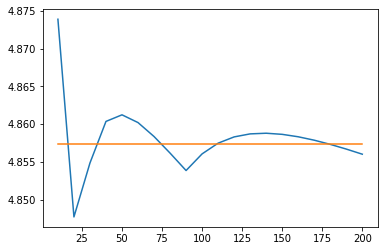

In [ ]:

n = 20

# Model Parameters 
S = 20
K = 18
r = 0.15
T = 12/12
v = 0.25
style = 'euro'
type  = 'call'

# Initialize array 
optionPrices = np.empty((20,3))

# Populate array
for i in range(0,n):
    steps = (i+1)*10 
    optionPrices[i, 0] = steps
    optionPrices[i, 1] = crr_binomial_tree(S, K, r, T, steps, v, style, type)
    optionPrices[i, 2] = black_scholes(S, K, r, T, steps, v, style, type)

print(optionPrices)

plt.plot(optionPrices[:,0],optionPrices[:,1], label='CRR Price')
plt.plot(optionPrices[:,0],optionPrices[:,2], label='B-S Price')
plt.show()


## Calculating Option Prices

### Monster Beverage Corp.

In [ ]:
# Monster Beverage 
crr_price = crr_binomial_tree(91.36, 95.00, 0.0007, 150/252, 800, 0.8218, 1)
bs_price  =     black_scholes(91.36, 95.00, 0.0007, 150/252, 100, 0.8218, 1)
print("________________________________________________________________\n")
print("Monster Beverage Corp.")
print("Expiry: June 18th")
print("CRR European Call Price: $" + "{:3.3f}".format(crr_price))
print("B-S European Call Price: $" + "{:3.3f}".format(bs_price))

________________________________________________________________

Monster Beverage Corp.
Expiry: June 18th
CRR European Call Price: $21.416
B-S European Call Price: $21.417


## Carvana 

In [ ]:
# Carvana 
crr_price = crr_binomial_tree(265.32, 267.50, 0.00063, 15/252, 100, 0.6065, 1)
bs_price  =     black_scholes(265.32, 267.50, 0.00063, 15/252, 100, 0.6065, 1)
print("________________________________________________________________\n")
print("Carvana Co.")
print("Expiry: April 16th")
print("CRR European Call Price: $" + "{:3.2f}".format(crr_price))
print("B-S European Call Price: $" + "{:3.2f}".format(bs_price))

In [ ]:
# Monster Beverage Call Option 
c
bs_price = black_scholes(91.36, 93.00, 0.007, 50/252, 8, 0.8218, 1)
print("________________________________________________________________\n")
print("Monster Beverage Corp.")
print("Expiry: June 18th")
print("CRR European Call Price: $" + "{:3.2f}".format(price))
print("B-S European Call Price: $" + "{:3.2f}".format(bs_price))
print("________________________________________________________________\n")

## Debugging Pricing Code 

Use some provided examples from coursework online to verify results 
for European and American pricing. 

Generally, it should be expected that the added excercise flexibility of American style options would make them more expensive to buy. The price of American options should be equal to, or greater than, the price of a European option with the same contract parameters. 

In [ ]:
# Theoretical example from practice question documents (Problem 18.12)
# European put price should be $1.14
# American put price should be $1.28

crr_visualize_tree(20, 18, 0.15, 12/12, 4, 0.40, 'amer', 'put')
crr_visualize_tree(20, 18, 0.15, 12/12, 4, 0.40, 'euro', 'put')


Inputs:

T : 12.00 months
t :    4 periods

Tree Parameters:

u : 1.2214
d : 0.8187
p : 0.545

CRR Stock Price Tree:

  20.000   24.428   29.836   36.442   44.511 
     nan   16.375   20.000   24.428   29.836 
     nan      nan   13.406   16.375   20.000 
     nan      nan      nan   10.976   13.406 
     nan      nan      nan      nan    8.987 



CRR Option Price Tree:

   1.288    0.387    0.000    0.000    0.000 
     nan    2.476    0.882    0.000    0.000 
     nan      nan    4.594    2.013    0.000 
     nan      nan      nan    7.024    4.594 
     nan      nan      nan      nan    9.013 


Option Price: $  1.29
______________________________________________________________

Inputs:

T : 12.00 months
t :    4 periods

Tree Parameters:

u : 1.2214
d : 0.8187
p : 0.545

CRR Stock Price Tree:

  20.000   24.428   29.836   36.442   44.511 
     nan   16.375   20.000   24.428   29.836 
     nan      nan   13.406   16.375   20.000 
     nan      nan      nan   10.976   13.406 
    

In [ ]:

crr = crr_binomial_tree(20, 18, 0.15, 12/12, 50, 0.40, 'euro', 'put')
bs = black_scholes(20, 18, 0.15, 12/12, 4, 0.40, 'euro', 'put')
print(bs)
print(crr)

1.1030371926735958
1.0966293266078704
